# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers
from typing import Optional
from visualization import scatter_pred_vs_true, plot_validation_performance
import pickle

import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Hack to find the conda activate path since bash scripts
# # don't necessarily work with the conda activate command
# conda_path = !which conda
# conda_path = list(conda_path)[0]
# conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
# if not conda_activate_path.is_file():
#     raise FileNotFoundError(
#         "Could not find your conda activate path needed for running bash scripts."
#     )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
WARM_START: Optional[str] = "cavity_models/model_epoch_02.pt"
DEVICE: str = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT: float = 0.9
BATCH_SIZE: int = 100
SHUFFLE_PDBS: bool = True
LEARNING_RATE: float = 2e-4
EPOCHS: int = 6
PATIENCE_CUTOFF: int = 1
EPS: float = 1e-9

# Parameters for simulation stride
STRIDE_FRAGMENTS: int = 2  # 2
STRIDE_MD: int = 4  # 4

# Parameters specific to downstream model
BATCH_SIZE_DDG: int = 40
SHUFFLE_DDG: bool = True
LEARNING_RATE_DDG: float = 1e-3
EPOCHS_DDG: int = 200

# Mapping between data keys and titles/colors for plots
dataset_name_mapping = {
    "dms": "DMS",
    "guerois": "Guerois",
    "protein_g": "Protein G",
    "symmetric_direct": "Symmetric (Direct)",
    "symmetric_inverse": "Symmetric (Inverse)",
}

dataset_color_mapping = {
    "dms": "steelblue",
    "guerois": "firebrick",
    "protein_g": "forestgreen",
    "symmetric_direct": "olive",
    "symmetric_inverse": "olive",
}

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [5]:
if WARM_START is None:
    parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
    if SHUFFLE_PDBS:
        random.shuffle(parsed_pdb_filenames)
    (
        dataloader_train,
        dataset_train,
        dataloader_val,
        dataset_val,
    ) = helpers.train_val_split(
        parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_02.pt


<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
if WARM_START is None:
    # Define model
    cavity_model_net = CavityModel(DEVICE).to(DEVICE)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    # Train loop
    best_model_path = helpers.train_loop(
        dataloader_train,
        dataloader_val,
        cavity_model_net,
        loss_function,
        optimizer,
        EPOCHS,
        PATIENCE_CUTOFF,
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_02.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [7]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [8]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [9]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [10]:
helpers.populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [11]:
# Load best performing cavity model from previos training
if WARM_START:
    best_model_path = WARM_START

cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

CavityModel(
  (conv1): Sequential(
    (0): Conv3d(6, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (1): ReLU()
    (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Flatten()
  )
  (dense1): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense2): Linear(in_features=128, out_features=21, bias=True)
)

<IPython.core.display.Javascript object>

In [12]:
if not os.path.exists("processed_data_frames.pickle"):
    helpers.populate_dfs_with_nlls_and_nlfs(
        ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS
    )

<IPython.core.display.Javascript object>

## Process results without downstream model

### Symmetric, use both structures

In [13]:
if not os.path.exists("processed_data_frames.pickle"):
    helpers.get_predictions_both_structures(ddg_data_dict)

<IPython.core.display.Javascript object>

### Phaistos statistics

In [14]:
# # Output 11 amino acid sequence fragment for MC simulations (Only done once)
# helpers.output_sequence_fragments_to_csv(ddg_data_dict)

<IPython.core.display.Javascript object>

In [15]:
if not os.path.exists("processed_data_frames.pickle"):
    for data_set in ["protein_g", "dms", "guerois"]:
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_net,
            DEVICE,
            EPS,
            is_wt=True,
            stride=STRIDE_FRAGMENTS,
        )
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_net,
            DEVICE,
            EPS,
            is_wt=False,
            stride=STRIDE_FRAGMENTS,
        )

        helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

<IPython.core.display.Javascript object>

##### Molecular dynamics

In [16]:
if not os.path.exists("processed_data_frames.pickle"):
    # Infer NLLs for WT and MT  in columns wt_nll_md and mt_nll_md
    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "protein_g",
        DEVICE,
        EPS,
        cavity_model_infer_net,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=True,
    )

    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "guerois",
        DEVICE,
        EPS,
        cavity_model_infer_net,
        stride=STRIDE_MD,
        is_npt_ensemble=False,  # Maybe fix the bug with NPT ensemble
        use_residue_number_map=True,
    )

    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "dms",
        DEVICE,
        EPS,
        cavity_model_infer_net,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=False,
    )

<IPython.core.display.Javascript object>

In [17]:
if not os.path.exists("processed_data_frames.pickle"):
    # Calculate DDgs
    helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "protein_g")
    helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "guerois")
    helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "dms")

<IPython.core.display.Javascript object>

# Cache

In [18]:
if not os.path.exists("processed_data_frames.pickle"):
    with open("processed_data_frames.pickle", "wb") as handle:
        pickle.dump(ddg_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

# Load

In [19]:
with open("processed_data_frames.pickle", "rb") as handle:
    ddg_data_dict = pickle.load(handle)

<IPython.core.display.Javascript object>

# Downstream model

### Performance without augmentation Vanilla

Define training dataloader and eval dataloaders

In [20]:
# from cavity_model import DDGToTensor, DDGToTensorPhaistosAndMD

<IPython.core.display.Javascript object>

In [21]:
# ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
#     ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
# )
# ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
#     ddg_data_dict, DDGToTensor
# )

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [22]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [23]:
# for data_set in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(
#         f"Trained on {dataset_name_mapping[data_set]}",
#         pearsons_r_results_dict[data_set],
#     )

<IPython.core.display.Javascript object>

### Performance without augmentation With Phaistos and MD

In [24]:
# ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
#     ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
# )
# ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
#     ddg_data_dict, DDGToTensorPhaistosAndMD
# )

<IPython.core.display.Javascript object>

In [25]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [26]:
# for data_set in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(
#         f"Trained on {dataset_name_mapping[data_set]}",
#         pearsons_r_results_dict[data_set],
#     )

<IPython.core.display.Javascript object>

### Performance with augmentation Vanilla

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [27]:
# ddg_data_dict_augmented = helpers.augment_with_reverse_mutation(ddg_data_dict)

<IPython.core.display.Javascript object>

Define training dataloader (augmented data) and eval dataloaders (original data)

In [28]:
# ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
#     ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
# )
# ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
#     ddg_data_dict, DDGToTensor
# )

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [29]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [30]:
# for data_set in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(
#         f"Trained on {dataset_name_mapping[data_set]}",
#         pearsons_r_results_dict[data_set],
#     )

<IPython.core.display.Javascript object>

### Performance with augmentation With Phaistos and MD

In [31]:
# ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
#     ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
# )
# ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
#     ddg_data_dict, DDGToTensorPhaistosAndMD
# )

<IPython.core.display.Javascript object>

In [32]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [33]:
# for data_set in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(
#         f"Trained on {dataset_name_mapping[data_set]}",
#         pearsons_r_results_dict[data_set],
#     )

<IPython.core.display.Javascript object>

# Figures

### Vanilla PDB statistics

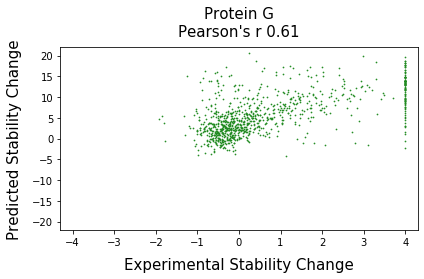

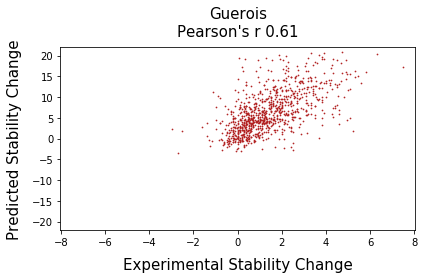

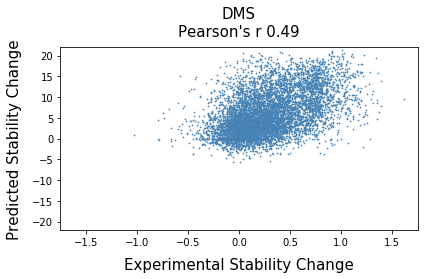

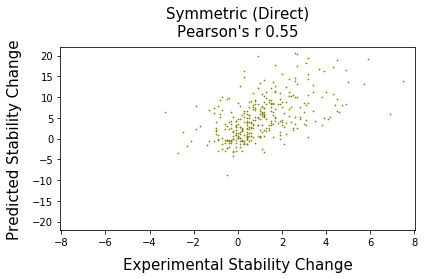

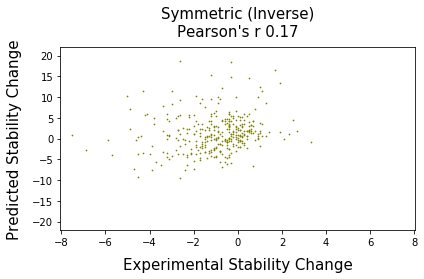

<IPython.core.display.Javascript object>

In [34]:
VANILLA_PDB_STATISTICS_RS = {}
for data_key in [
    "protein_g",
    "guerois",
    "dms",
    "symmetric_direct",
    "symmetric_inverse",
]:
    if data_key == "symmetric_direct":
        ddg_col = "ddg_dir"
        ddg_pred_col = "ddg_pred_no_ds_dir"
    elif data_key == "symmetric_inverse":
        ddg_col = "ddg_inv"
        ddg_pred_col = "ddg_pred_no_ds_inv"
    else:
        ddg_col = "ddg"
        ddg_pred_col = "ddg_pred_no_ds"

    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict[data_key][ddg_col],
        ddg_data_dict[data_key][ddg_pred_col],
        color=dataset_color_mapping[data_key],
        title=dataset_name_mapping[data_key],
    )

    VANILLA_PDB_STATISTICS_RS[data_key] = pearsons_r

### Vanilla IDP statistics

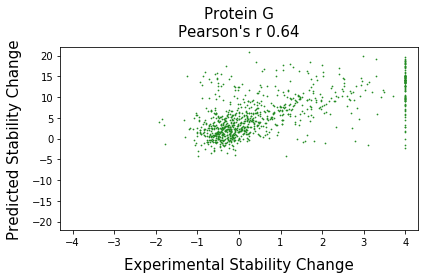

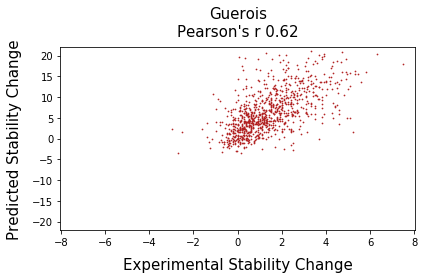

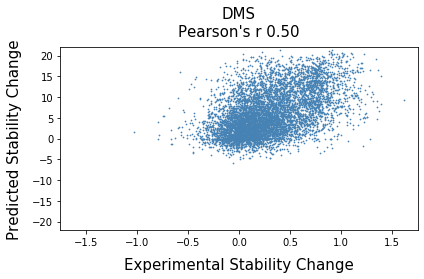

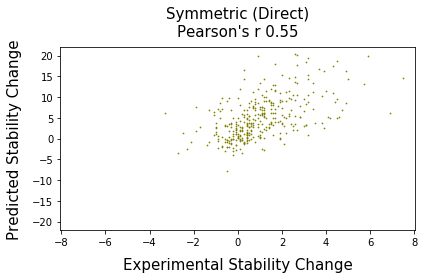

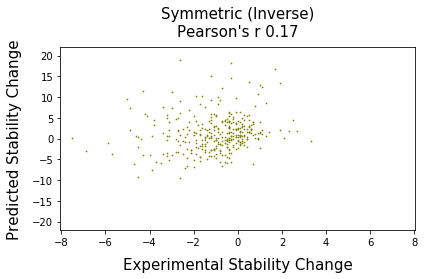

<IPython.core.display.Javascript object>

In [35]:
VANILLA_IDP_STATISTICS_RS = {}
for data_key in [
    "protein_g",
    "guerois",
    "dms",
    "symmetric_direct",
    "symmetric_inverse",
]:
    if data_key == "symmetric_direct":
        ddg_col = "ddg_dir"
        ddg_pred_col = "ddg_pred_idp_no_ds_dir"
    elif data_key == "symmetric_inverse":
        ddg_col = "ddg_inv"
        ddg_pred_col = "ddg_pred_idp_no_ds_inv"
    else:
        ddg_col = "ddg"
        ddg_pred_col = "ddg_pred_idp_no_ds"

    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict[data_key][ddg_col],
        ddg_data_dict[data_key][ddg_pred_col],
        color=dataset_color_mapping[data_key],
        title=dataset_name_mapping[data_key],
    )
    VANILLA_IDP_STATISTICS_RS[data_key] = pearsons_r

### Both structure symmetric

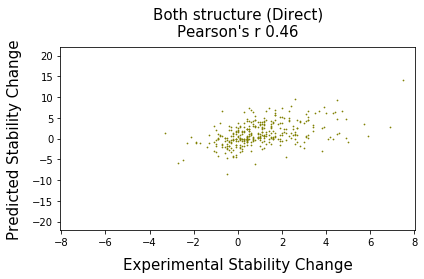

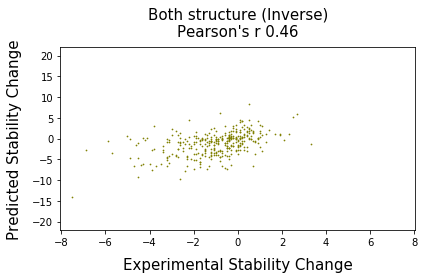

<IPython.core.display.Javascript object>

In [36]:
VANILLA_BOTH_STRUCTURES_RS = {}
# Plot prediction for ddg direct using both structures
fig, ax, pearsons_r = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="olive",
    title="Both structure (Direct)",
)
VANILLA_BOTH_STRUCTURES_RS["symmetric_direct"] = pearsons_r

# Plot prediction for ddg inverse using both structures
fig, ax, pearsons_r = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="olive",
    title="Both structure (Inverse)",
)
VANILLA_BOTH_STRUCTURES_RS["symmetric_inverse"] = pearsons_r


### Phaistos statistics

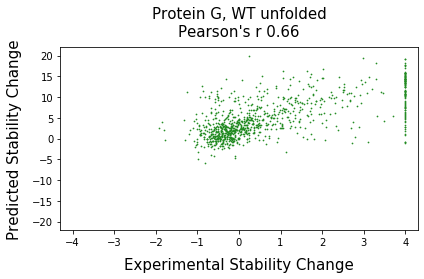

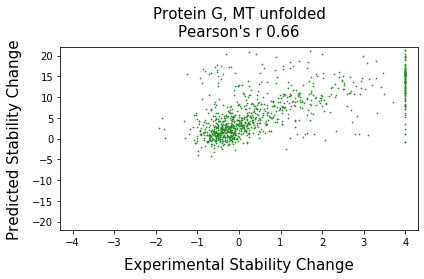

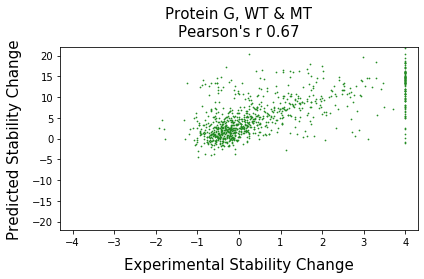

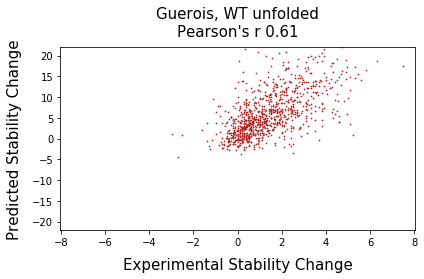

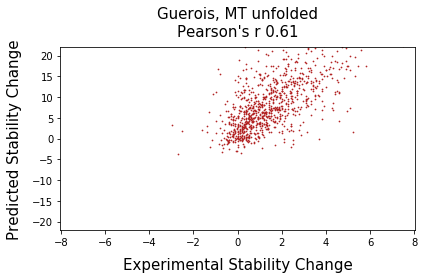

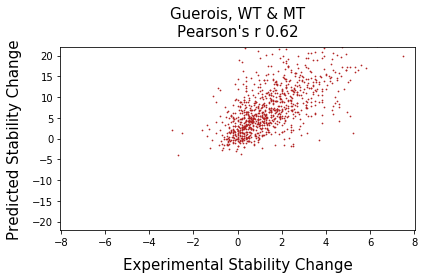

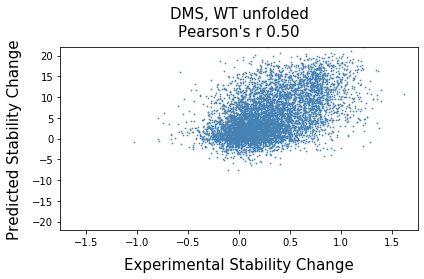

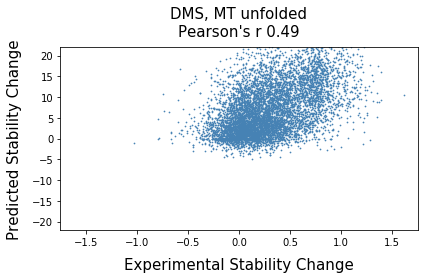

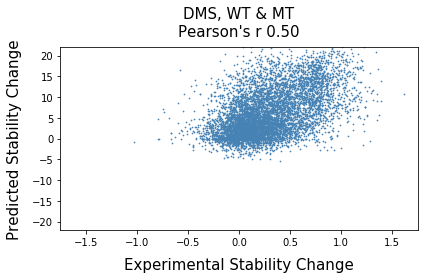

<IPython.core.display.Javascript object>

In [37]:
VANILLA_PHAISTOS_STATISTICS_RS = {}
for data_set in ["protein_g", "guerois", "dms"]:
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, WT unfolded",
    )
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MT unfolded",
    )

    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, WT & MT",
    )
    VANILLA_PHAISTOS_STATISTICS_RS[data_set] = pearsons_r


### Molecular Dynamics

protein_g
guerois
dms


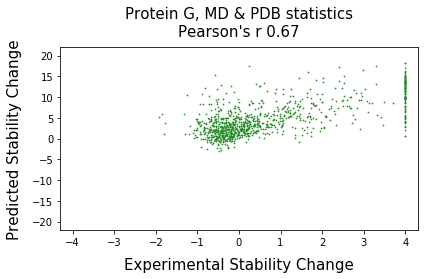

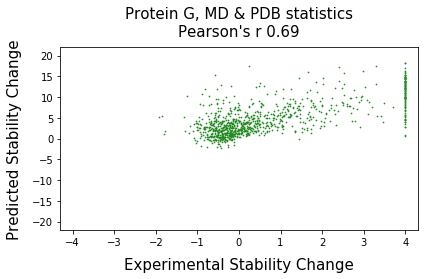

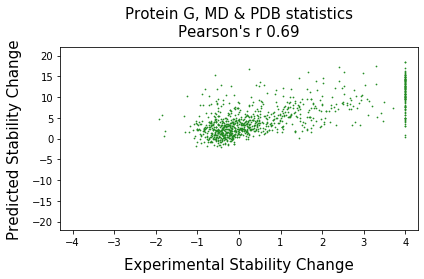

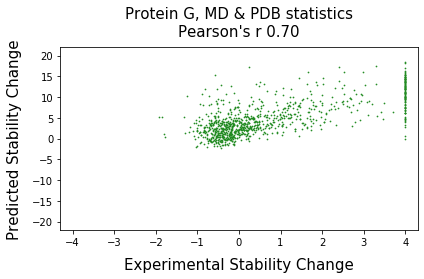

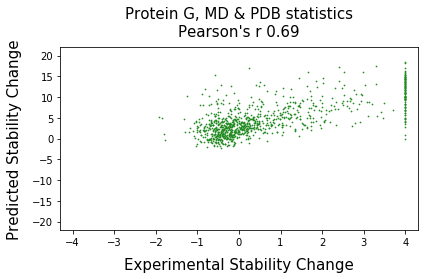

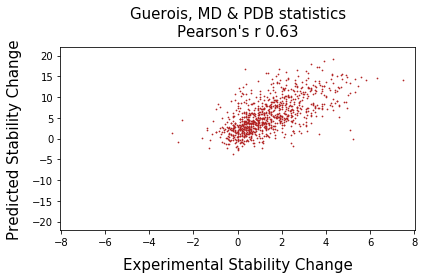

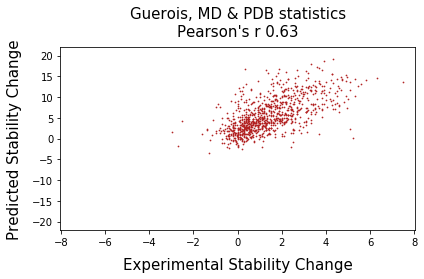

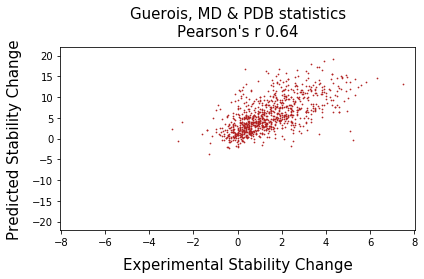

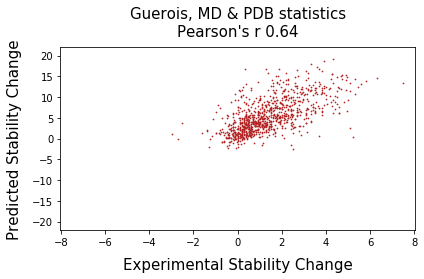

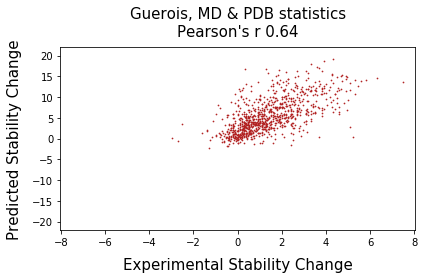

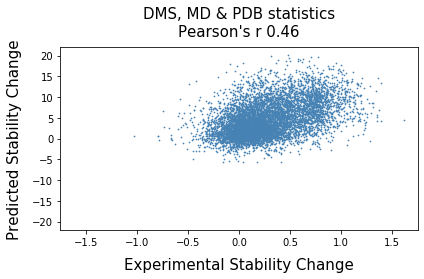

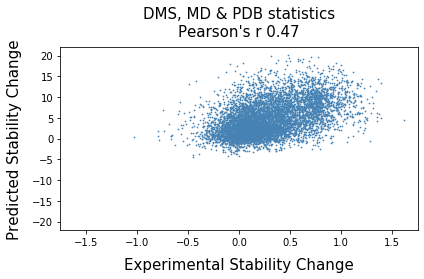

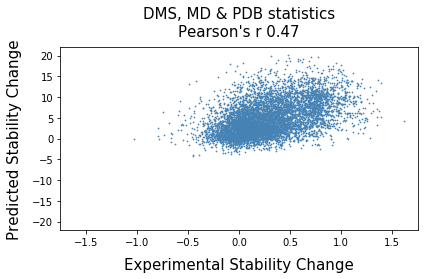

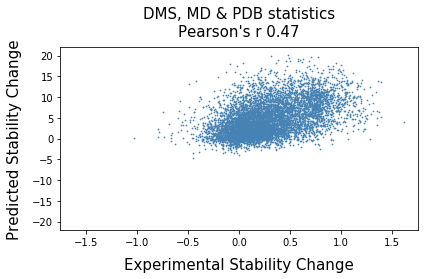

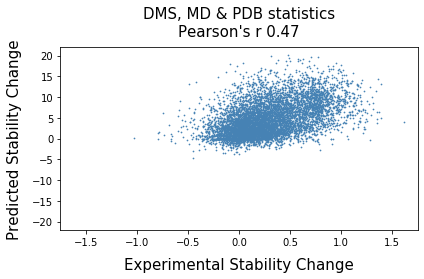

<IPython.core.display.Javascript object>

In [38]:
VANILLA_PDB_STATISTICS_MD_RS = {}
for data_set in ["protein_g", "guerois", "dms"]:
    print(data_set)
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds_1"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
    )
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds_2"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
    )
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds_5"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
    )
    fig, ax, _ = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds_20"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
    )
    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict[data_set]["ddg"],
        ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds_all"],
        color=dataset_color_mapping[data_set],
        title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
    )
    VANILLA_PDB_STATISTICS_MD_RS[data_set] = pearsons_r


# PLOTS FOR PAPER

## Figure 2:

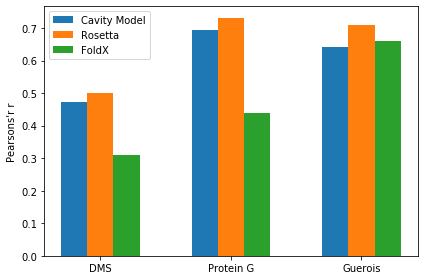

<IPython.core.display.Javascript object>

In [39]:
labels = ["DMS", "Protein G", "Guerois"]

cavity_correlations = [
    VANILLA_PDB_STATISTICS_MD_RS["dms"],
    VANILLA_PDB_STATISTICS_MD_RS["protein_g"],
    VANILLA_PDB_STATISTICS_MD_RS["guerois"],
]
rosetta_correlations = [0.5, 0.73, 0.71]
foldx_correlations = [0.31, 0.44, 0.66]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, cavity_correlations, width, label="Cavity Model")
rects2 = ax.bar(x, rosetta_correlations, width, label="Rosetta")
rects3 = ax.bar(x + width, foldx_correlations, width, label="FoldX")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

## Figure 3:

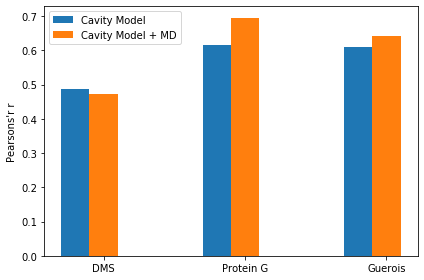

<IPython.core.display.Javascript object>

In [40]:
labels = ["DMS", "Protein G", "Guerois"]

cavity_correlations = [
    VANILLA_PDB_STATISTICS_RS["dms"],
    VANILLA_PDB_STATISTICS_RS["protein_g"],
    VANILLA_PDB_STATISTICS_RS["guerois"],
]
cavity_md_correlations = [
    VANILLA_PDB_STATISTICS_MD_RS["dms"],
    VANILLA_PDB_STATISTICS_MD_RS["protein_g"],
    VANILLA_PDB_STATISTICS_MD_RS["guerois"],
]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, cavity_correlations, width, label="Cavity Model")
rects2 = ax.bar(x, cavity_md_correlations, width, label="Cavity Model + MD")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

## Plot 4:

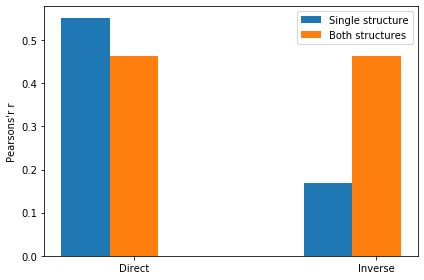

<IPython.core.display.Javascript object>

In [41]:
labels = ["Direct", "Inverse"]

cavity_single_structure = [
    VANILLA_PDB_STATISTICS_RS["symmetric_direct"],
    VANILLA_PDB_STATISTICS_RS["symmetric_inverse"],
]
cavity_both_structure = [
    VANILLA_BOTH_STRUCTURES_RS["symmetric_direct"],
    VANILLA_BOTH_STRUCTURES_RS["symmetric_inverse"],
]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, cavity_single_structure, width, label="Single structure")
rects2 = ax.bar(x, cavity_both_structure, width, label="Both structures")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Plot 5:

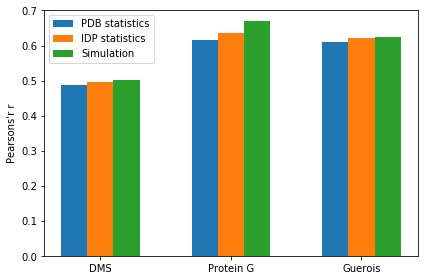

<IPython.core.display.Javascript object>

In [42]:
labels = ["DMS", "Protein G", "Guerois"]

# cavity_pdb_statistics = [0.49, 0.61, 0.61]
# cavity_idp_statistics = [0.50, 0.64, 0.62]
# cavity_phaistos_statistics = [0.49, 0.66, 0.61]

cavity_pdb_statistics = [
    VANILLA_PDB_STATISTICS_RS["dms"],
    VANILLA_PDB_STATISTICS_RS["protein_g"],
    VANILLA_PDB_STATISTICS_RS["guerois"],
]
cavity_idp_statistics = [
    VANILLA_IDP_STATISTICS_RS["dms"],
    VANILLA_IDP_STATISTICS_RS["protein_g"],
    VANILLA_IDP_STATISTICS_RS["guerois"],
]
cavity_phaistos_statistics = [
    VANILLA_PHAISTOS_STATISTICS_RS["dms"],
    VANILLA_PHAISTOS_STATISTICS_RS["protein_g"],
    VANILLA_PHAISTOS_STATISTICS_RS["guerois"],
]


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, cavity_pdb_statistics, width, label="PDB statistics")
rects2 = ax.bar(x, cavity_idp_statistics, width, label="IDP statistics")
rects3 = ax.bar(x + width, cavity_phaistos_statistics, width, label="Simulation")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()